# 3D CNN

In [2]:
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import tqdm
import pandas as pd
import numpy as np
import pickle
from tensorflow.keras.optimizers import Adam
from keras import backend as K
import glob
import keras_video
import keras_video.utils
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.models import load_model
from keras.callbacks import History
from keras_video import VideoFrameGenerator
from sklearn.preprocessing import LabelBinarizer


In [ ]:
# split the files into training(80%)and testing set(20%)

input_folder = 'Anomaly_Dataset/Anomaly_Detection/' # crime and normal should be in here
output_folder = 'Anomaly_Dataset/Anomaly_Detection/'
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8,.0,.2), group_prefix=None) # default values

In [ ]:
# use sub directories names as classes
classes = ['Crime','Normal']
classes.sort()

# some global params
img_size = (112, 112)
CHANNELS = 3
num_frames = 10 # number of frame extracted for each videos
batch_size = 64 # batch size
# generator produces 8 sequences of 5 frames picked from videos.

# pattern to get videos and classes of traning set
glob_pattern='Anomaly_Dataset\Anomaly_Detection/train/{classname}/*.mp4'

# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255,
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
    
# Create the training set
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=num_frames,
    split=.2, 
    shuffle=True,
    batch_size=batch_size,
    target_shape=img_size,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=False)

In [ ]:
valid = train.get_validation_generator()

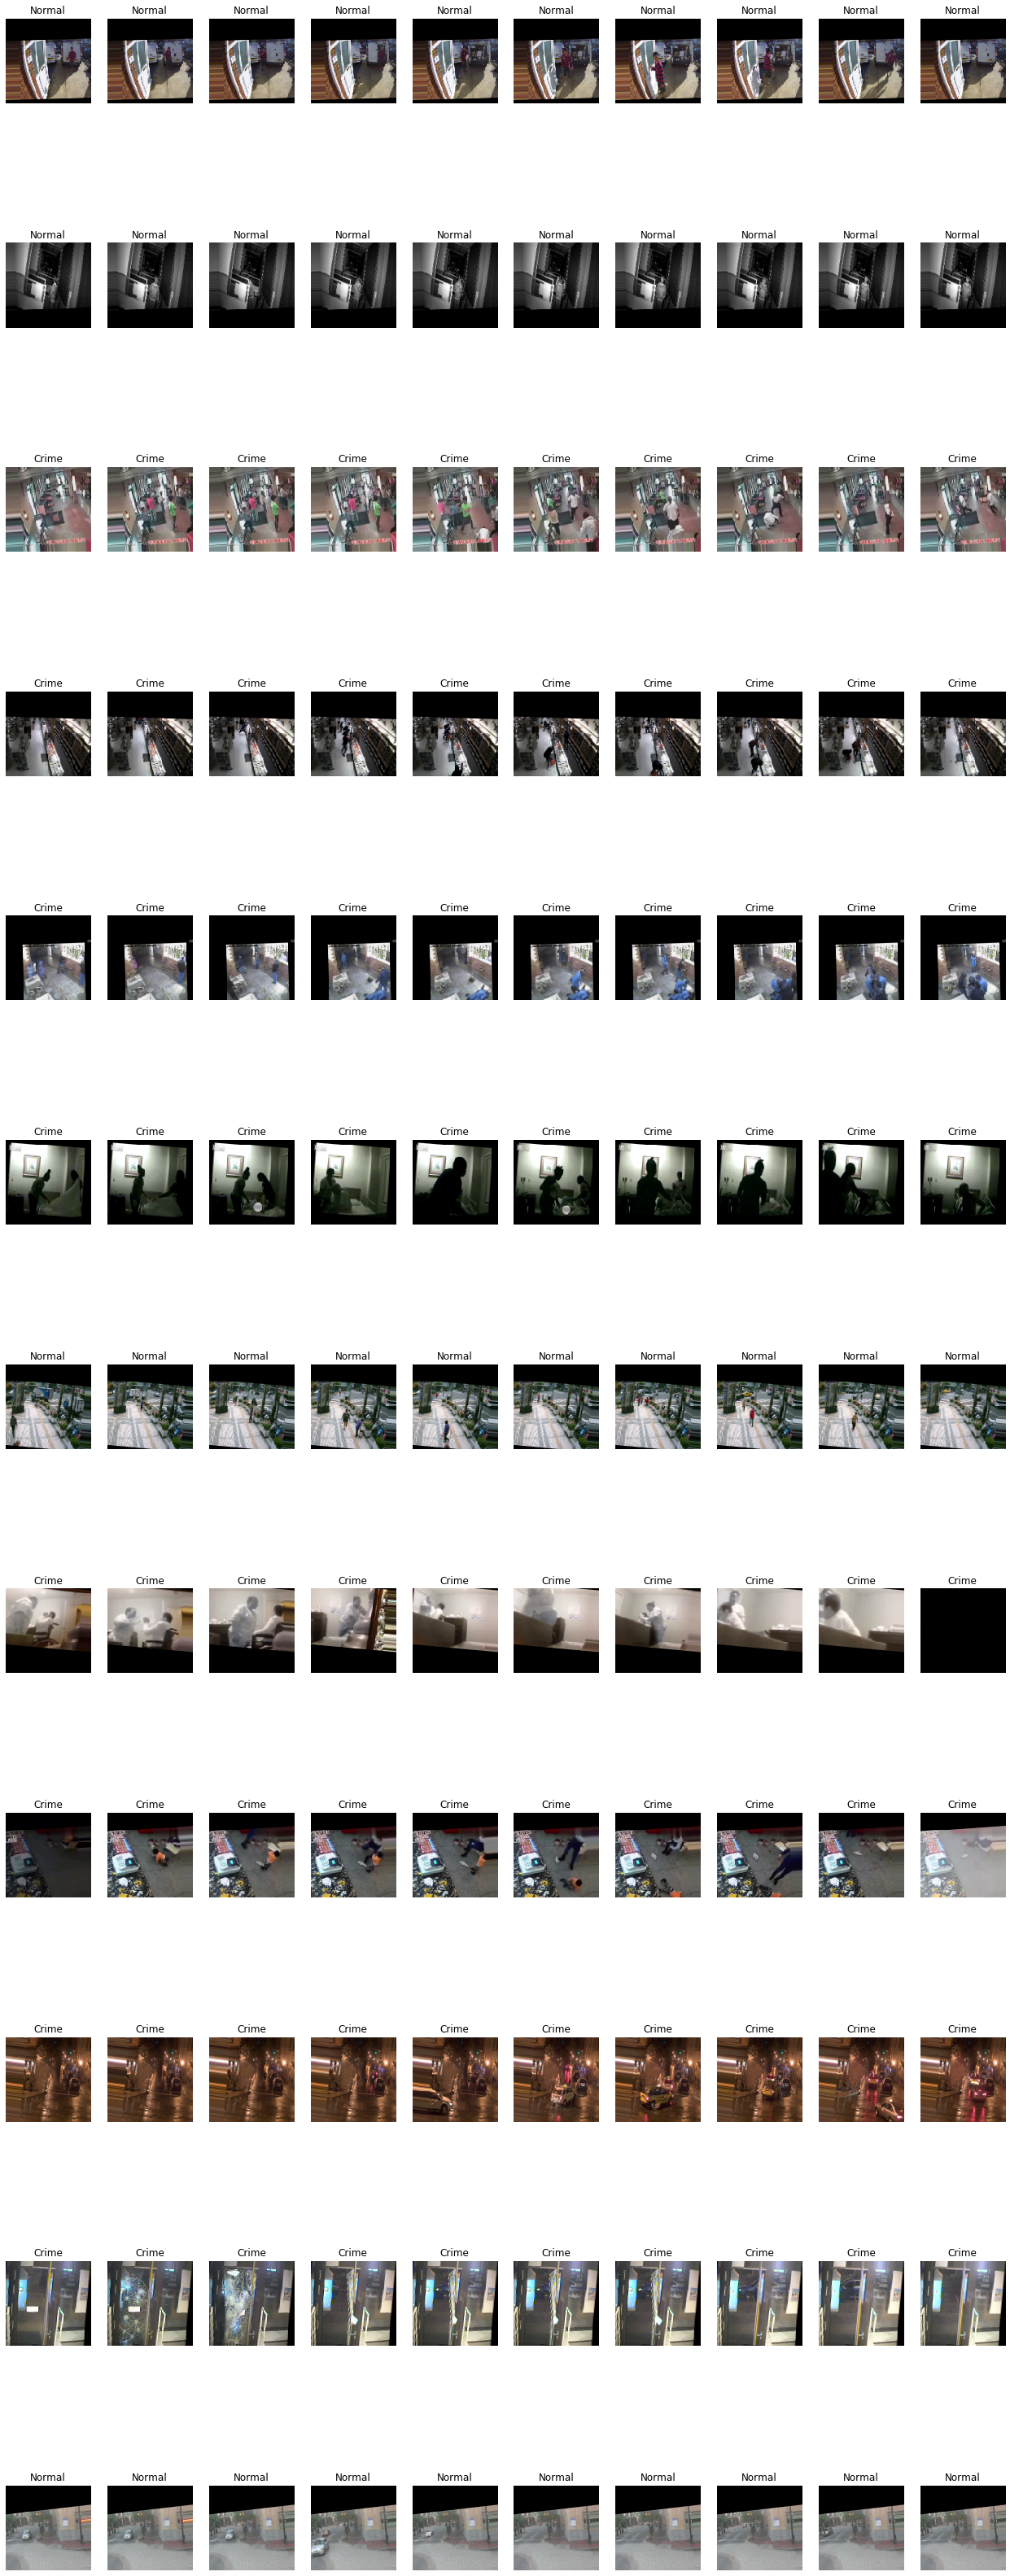

In [4]:
keras_video.utils.show_sample(train,random=True)

In [5]:
class_weight = {0:1, 1: 2.7}

## Training

In [6]:
shape=(10, 112, 112, 3)

model = Sequential()
model.add(Conv3D(32, kernel_size=(3,3,3), input_shape=shape, padding='same',activation='relu'))
model.add(Conv3D(32, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))

model.add(Conv3D(64, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(Conv3D(64, kernel_size=(3,3,3), padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 112, 112, 32)  2624      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 112, 112, 32)  27680     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 4, 38, 38, 32)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 38, 38, 32)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 38, 38, 64)     55360     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 4, 38, 38, 64)     110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 13, 13, 64)    

In [7]:
model.compile(loss="categorical_crossentropy",optimizer='adam', weighted_metrics=['accuracy'])

In [8]:
hist = model.fit_generator(train,validation_data=valid,verbose=1,epochs=20,shuffle=True,class_weight=class_weight)

Epoch 1/20


C:\Users\tfmev\Miniconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 0 could not be retrieved. It could be because a worker has died.
  UserWarning)


6/6 [==============================] - ETA: 14:08 - loss: 1.0491 - accuracy: 0.545 - ETA: 8:51 - loss: 2.3618 - accuracy: 0.557 - ETA: 5:40 - loss: 2.0023 - accuracy: 0.53 - ETA: 3:24 - loss: 1.7640 - accuracy: 0.52 - ETA: 1:34 - loss: 1.6196 - accuracy: 0.53 - 541s 90s/step - loss: 1.5203 - accuracy: 0.5278 - val_loss: 0.6963 - val_accuracy: 0.2969
Epoch 2/20
6/6 [==============================] - ETA: 5:10 - loss: 1.0935 - accuracy: 0.58 - ETA: 4:03 - loss: 1.0149 - accuracy: 0.50 - ETA: 3:01 - loss: 1.0231 - accuracy: 0.51 - ETA: 2:00 - loss: 1.0230 - accuracy: 0.51 - ETA: 1:00 - loss: 1.0228 - accuracy: 0.52 - 366s 61s/step - loss: 1.0084 - accuracy: 0.5028 - val_loss: 0.6925 - val_accuracy: 0.5312
Epoch 3/20
6/6 [==============================] - ETA: 5:03 - loss: 0.8614 - accuracy: 0.58 - ETA: 4:01 - loss: 0.9046 - accuracy: 0.57 - ETA: 3:00 - loss: 0.9832 - accuracy: 0.50 - ETA: 2:00 - loss: 1.0106 - accuracy: 0.48 - ETA: 59s - loss: 1.0172 - accuracy: 0.4839 - 365s 61s/step - l

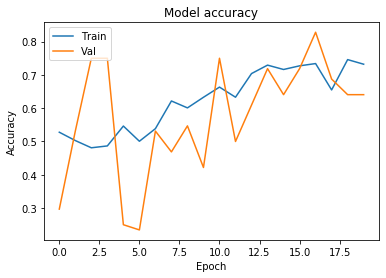

In [10]:
#Visualize the models accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

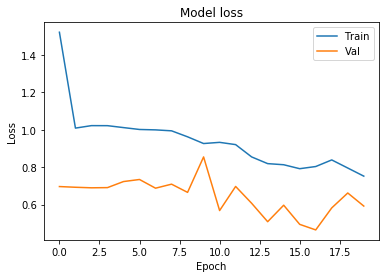

In [11]:
#Visualize the models loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## Testing

In [4]:
classes = ['Crime','Normal']
classes.sort()

img_size = (112, 112)
CHANNELS = 3
num_frames = 10 # number of frame extracted for each videos
batch_size = 8

test_dir='D:\Anomaly_Dataset\Anomaly_Detection/test/{classname}/*.mp4'

test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=test_dir,
    nb_frames=num_frames,
    shuffle=True,
    batch_size=batch_size,
    target_shape=img_size,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=False)

Total data: 2 classes for 55 files for train


In [20]:
scores = threedee_model.evaluate_generator(test)
print("Accuracy = ",scores[1])
print("Loss = ",scores[0])

  ...
    to  
  ['...']
Accuracy =  0.5590909
Loss =  0.698015191338279


## Demo

In [22]:
y_train = np.load('y_train.npy')

y_test = np.load('y_test.npy')

total_labels = np.concatenate((y_train, y_test), axis=0)
labelbin = LabelBinarizer()
lb = labelbin.fit_transform(total_labels)

In [23]:
from collections import deque

# open the video file to classify
capture = cv2.VideoCapture(r"D:\Anomaly_Dataset\Anomaly_Detection\test\Normal\Normal_Videos_051_x264.mp4")
width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))   # float
height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float
Queue = deque(maxlen=180)
writer = None

In [ ]:
# loop over frames from the video file stream
while True:
    
    # read the next frame from the file
    (grabbed, frame) = capture.read()

    # if the frame was not grabbed, then we have reached the end of the stream
    if not grabbed:
        break


    # clone the output frame # ordering, resize the frame to a fixed 224x224, and then perform mean subtraction
    output = frame.copy()
    frame = cv2.resize(frame,(112,112))
    #frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY )

    # make predictions on the frame and then update the predictions queue
    array = np.expand_dims(frame, axis=0)
    preds =threedee_model.predict(np.expand_dims(array, axis=0),10)
    Queue.append(preds)

    # perform prediction averaging over the current history of previous predictions
    results = np.array(Queue).mean(axis=0)
    i = np.argmax(results)
    label = labelbin.classes_[i]
    
    # draw the activity on the output frame
    if label ==0:
        text = "Crime Detected"
    if label ==1:
        text = "No Crime Detected"
        
    cv2.putText(output, text, (25, 20), cv2.FONT_HERSHEY_SIMPLEX,1, (0, 255, 0), 2)

    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter("output_3dcnn.avi", fourcc, 30,(width, height))

    # write the output frame to disk
    writer.write(output)

    # show the output image
    cv2.imshow("Output", output)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# release the file pointers
writer.release()
capture.release()
cv2.destroyAllWindows()